In [265]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import linear_model as lm
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [218]:
path = 'data/conjoint_survey_results.csv'

In [219]:
data = pd.read_csv(path)

In [220]:
data.head()

,Product,Total
0,Balcony Level<br />\nBack Half<br />\nNo IMAG<...,2
1,Middle Level<br />\nBack Half<br />\nIMAG<br /...,23
2,Middle Level<br />\nBack Half<br />\nNo IMAG<b...,4
3,Middle Level<br />\nFront Half<br />\nNo IMAG<...,7
4,Balcony Level<br />\nBack Half<br />\nNo IMAG<...,2


### Get all unique attributes

We will use these to set the column headers for our dataframe along with a "score" header. The score header will be set to the Total line in the dataframe above ("data"). 

In [221]:
# Getting all unique attributes
all_attributes = set()
for product in data['Product']:
    for attribute in product.split("<br />\n"):
        all_attributes.add(attribute)

In [222]:
all_attributes.add('score')
all_attributes

{'$100',
 '$25',
 '$50',
 '$75',
 '1 hour(s)',
 '2 hour(s)',
 'Back Half',
 'Balcony Level',
 'Floor Level',
 'Front Half',
 'IMAG',
 'Middle Level',
 'No IMAG',
 'Tier 1 Composer',
 'Tier 2 Composer',
 'Tier 3 Composer',
 'score'}

### Initialize the DataFrame

In [256]:
# Create a dataframe with the attributes as the column headers
conjoint_df = pd.DataFrame(columns=all_attributes)

#### Reorder the column headers

In [257]:
col_order = ['score', '$25', '$50', '$75', '$100', 'IMAG', 'No IMAG', 
             '1 hour(s)', '2 hour(s)', 'Back Half', 'Front Half', 
             'Floor Level', 'Middle Level', 'Balcony Level', 
             'Tier 1 Composer', 'Tier 2 Composer', 'Tier 3 Composer']

# Reorder columns:
conjoint_df = conjoint_df[col_order]

In [258]:
conjoint_df

,score,$25,$50,$75,$100,IMAG,No IMAG,1 hour(s),2 hour(s),Back Half,Front Half,Floor Level,Middle Level,Balcony Level,Tier 1 Composer,Tier 2 Composer,Tier 3 Composer


### Append each row as appropriate to the initialized dataframe

We will loop through each row in the original dataframe. Within each loop, we create a new dataframe made up of one row of 17 values all set to 0 with the column headers equal to the column headers set above.

Then we will split the product names for that particular row by "<br />\n" as that is the syntax that the data was exported by. This will result in a list of products for that particular selection, like so:

['$25', 'IMAG', '2 hour(s)', 'Front Half', 'Middle Level', 'Tier 1 Composer']

Next, we filter through each value in that list and set it's value in the newly initialized dataframe as 1 instead of 0. Finally, we set the score in that dataframe equal to the total value provided by that row.

Finally, we append this new dataframe to originally initialized dataframe called "conjoint_df"

In [259]:
for row in np.array(data):
    data_array = pd.DataFrame([[0] * 17], columns=col_order)
    products = row[0].split("<br />\n")
    for product in products:
        data_array[product] = 1
    data_array['score'] = row[1]
    conjoint_df = conjoint_df.append(data_array)

In [260]:
conjoint_df.reset_index(drop=True, inplace=True)

In [261]:
conjoint_df.head()

,score,$25,$50,$75,$100,IMAG,No IMAG,1 hour(s),2 hour(s),Back Half,Front Half,Floor Level,Middle Level,Balcony Level,Tier 1 Composer,Tier 2 Composer,Tier 3 Composer
0,2,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0
1,23,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0
2,4,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0
3,7,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0
4,2,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0


### Set up variables for regression

In [262]:
# Set X equal to all vars except the 'score' column
X = conjoint_df.loc[:, conjoint_df.columns != 'score']

# Provide a constant
# This is to ensure that y takes a non-zero value when all other
#   explanatory variables are set to 0.
X['const'] = 1

# Set y equal to the score
y = conjoint_df.score

In [263]:
regression = sm.OLS(y.astype(float), X.astype(float)).fit()

In [268]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     4.714
Date:                Tue, 06 Aug 2019   Prob (F-statistic):            0.00135
Time:                        17:17:14   Log-Likelihood:                -87.784
No. Observations:                  32   AIC:                             197.6
Df Residuals:                      21   BIC:                             213.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
$25                 7.0568      2.007      3.516      0.002       2.883      11.231
$50                 2.1886      1.792      1.222      0.235      -1.537       5.914
$75                -2.2707      1.474     -1.541      0.138      -5.336       0.794
$100               -4.0420      1.464     -2.761      0.012      -7.086      -0.998
IMAG                4.9347      1.072      4.604      0.000       2.706       7.164
No IMAG            -2.0019      1.033     -1.938      0.066      -4.151       0.147
1 hour(s)          -0.2993      1.008     -0.297      0.769      -2.396       1.797
2 hour(s)           3.2320      0.993      3.255      0.004       1.167       5.297
Back Half           0.9696      0.949      1.022      0.319      -1.004       2.943
Front Half          1.9632      0.971      2.021      0.056      -0.057       3.983
Floor Level         2.4095      1.598      1.508      0.147      -0.914       5.733
Middle Level       -0.4112      1.211     -0.340      0.738      -2.929       2.107
Balcony Level       0.9344      1.536      0.608      0.549      -2.259       4.128
Tier 1 Composer     2.3499      1.491      1.576      0.130      -0.751       5.451
Tier 2 Composer     2.5013      1.364      1.834      0.081      -0.335       5.338
Tier 3 Composer    -1.9185      1.301     -1.475      0.155      -4.624       0.787
const               2.9327      0.257     11.414      0.000       2.398       3.467
==============================================================================
Omnibus:                        0.210   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.900   Jarque-Bera (JB):                0.058
Skew:                          -0.095   Prob(JB):                        0.972
Kurtosis:                       2.916   Cond. No.                     6.27e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.8e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Visualize the Results

In [318]:
# Color formatting
color_dict = {
    '$25': "green", 
    '$50': "green", 
    '$75': "green", 
    '$100': "green", 
    'IMAG': "blue", 
    'No IMAG': "blue",
    '1 hour(s)': "red",
    '2 hour(s)': "red", 
    'Back Half': "pink", 
    'Front Half': "pink", 
    'Floor Level': "orange", 
    'Middle Level': "orange", 
    'Balcony Level': "orange", 
    'Tier 1 Composer': "purple", 
    'Tier 2 Composer': "purple", 
    'Tier 3 Composer': "purple"
}

#### Attribute Importance

In [313]:
att_imp_df = pd.DataFrame(data=abs(regression.params), columns=["coeff"], index=X.columns)
att_imp_df.sort_values(by=["coeff"], ascending=False, inplace=True)

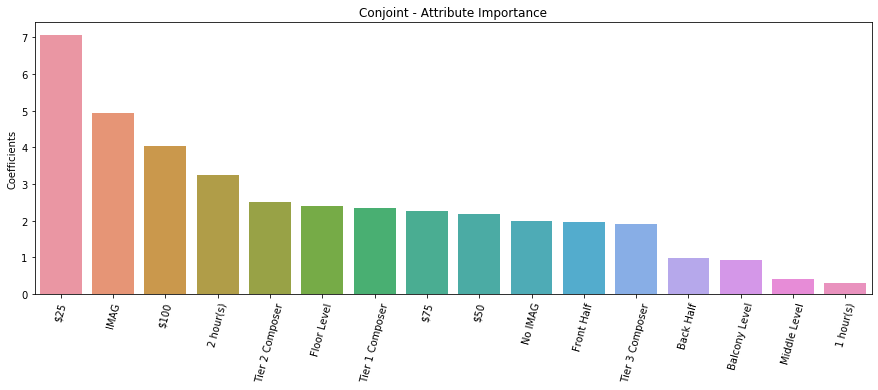

In [325]:
# Plot setup
plt.figure(figsize=[15,5])

# Plotting data
sns.barplot(data=att_imp_df.transpose().drop(columns=['const']))

# Plotting formatting
plt.title('Conjoint - Attribute Importance')
plt.ylabel('Coefficients')
plt.xticks(rotation=75)
plt.show()

#### Conjoint Utility Plot

In [321]:
utility_df = pd.DataFrame(data=[regression.params], columns=X.columns)

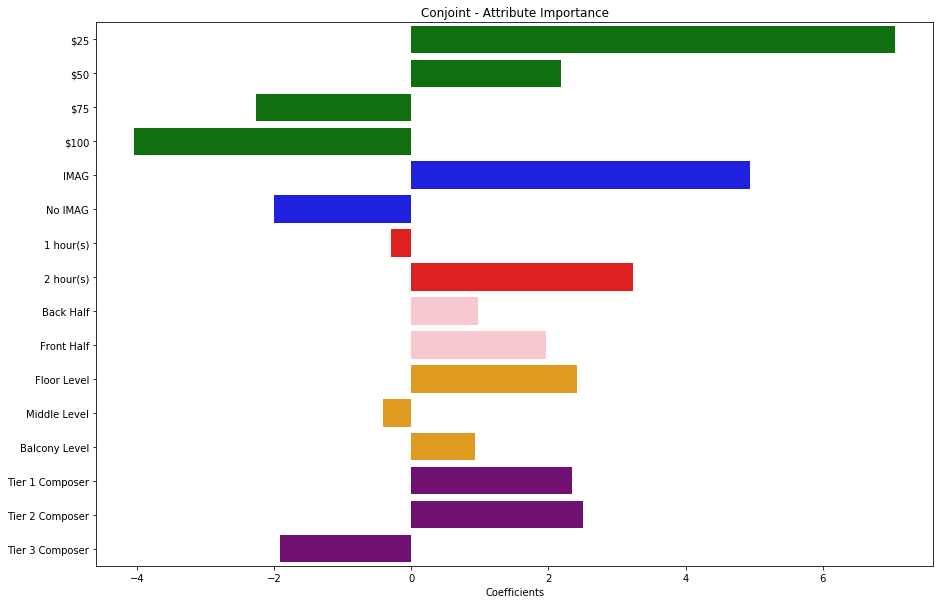

In [328]:
# Plot setup
plt.figure(figsize=[15,10])

# Plotting data
sns.barplot(data=utility_df.drop(columns=['const']),
           orient="h", palette=color_dict)

# Plotting formatting
plt.title('Conjoint - Attribute Importance')
plt.xlabel('Coefficients')
plt.show()